<b>Target :</b>

```1. Design a basic network with any parameters ```

```2. Reduce the parameteres <= target parameters```

In [12]:
!pip install torchsummary
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [13]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [14]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [15]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [16]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

def model_summary():
  model = Net().to(device)
  summary(model, input_size=(1, 28, 28))

cuda


In [17]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [18]:
def plot_result():
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

In [19]:
class Net(nn.Module):

    def conv_block (self, in_channels, out_channels, kernel_size, padding = 1) :
      return nn.Sequential(
            nn.Conv2d (in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding, bias = False),
            nn.ReLU())

    def out_block(self, in_channels, kernel_size = 1):
      return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=10, kernel_size = kernel_size, padding = 0, bias = False))


    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = self.conv_block(1, 32, 3)
        self.conv2 = self.conv_block(32, 32, 3, 0)
        self.conv3 = self.conv_block(32, 32, 3)
        self.conv4 = self.conv_block(32, 32, 3, 0)
        self.conv5 = self.conv_block(32, 32, 3)
        self.conv6 = self.conv_block(32, 32, 3, 0)
        self.conv7 = self.out_block(32, 3)
        self.pool = nn.MaxPool2d(2, 2)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

model_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 32, 26, 26]           9,216
              ReLU-4           [-1, 32, 26, 26]               0
         MaxPool2d-5           [-1, 32, 13, 13]               0
            Conv2d-6           [-1, 32, 13, 13]           9,216
              ReLU-7           [-1, 32, 13, 13]               0
            Conv2d-8           [-1, 32, 11, 11]           9,216
              ReLU-9           [-1, 32, 11, 11]               0
        MaxPool2d-10             [-1, 32, 5, 5]               0
           Conv2d-11             [-1, 32, 5, 5]           9,216
             ReLU-12             [-1, 32, 5, 5]               0
           Conv2d-13             [-1, 32, 3, 3]           9,216
             ReLU-14             [-1, 3

In [20]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.10251479595899582 Batch_id=468 Accuracy=75.89: 100%|██████████| 469/469 [00:19<00:00, 23.99it/s]



Test set: Average loss: 0.0993, Accuracy: 9689/10000 (96.89%)

EPOCH: 1


Loss=0.10946957021951675 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:16<00:00, 27.81it/s]



Test set: Average loss: 0.0658, Accuracy: 9770/10000 (97.70%)

EPOCH: 2


Loss=0.05727919936180115 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s]



Test set: Average loss: 0.0483, Accuracy: 9837/10000 (98.37%)

EPOCH: 3


Loss=0.07917632162570953 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]



Test set: Average loss: 0.0492, Accuracy: 9829/10000 (98.29%)

EPOCH: 4


Loss=0.008667080663144588 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:16<00:00, 28.40it/s]



Test set: Average loss: 0.0446, Accuracy: 9840/10000 (98.40%)

EPOCH: 5


Loss=0.021462619304656982 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]



Test set: Average loss: 0.0366, Accuracy: 9877/10000 (98.77%)

EPOCH: 6


Loss=0.006755380425602198 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:16<00:00, 28.61it/s]



Test set: Average loss: 0.0351, Accuracy: 9881/10000 (98.81%)

EPOCH: 7


Loss=0.005851952824741602 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 30.29it/s]



Test set: Average loss: 0.0355, Accuracy: 9886/10000 (98.86%)

EPOCH: 8


Loss=0.004451106768101454 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:15<00:00, 30.86it/s]



Test set: Average loss: 0.0327, Accuracy: 9902/10000 (99.02%)

EPOCH: 9


Loss=0.008984453044831753 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:16<00:00, 29.31it/s]



Test set: Average loss: 0.0328, Accuracy: 9905/10000 (99.05%)

EPOCH: 10


Loss=0.0687037855386734 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]



Test set: Average loss: 0.0286, Accuracy: 9910/10000 (99.10%)

EPOCH: 11


Loss=0.0037381534930318594 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:15<00:00, 30.40it/s]



Test set: Average loss: 0.0408, Accuracy: 9873/10000 (98.73%)

EPOCH: 12


Loss=0.09311467409133911 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]



Test set: Average loss: 0.0430, Accuracy: 9883/10000 (98.83%)

EPOCH: 13


Loss=0.003187078982591629 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:15<00:00, 29.99it/s]



Test set: Average loss: 0.0368, Accuracy: 9897/10000 (98.97%)

EPOCH: 14


Loss=0.0010763099417090416 Batch_id=468 Accuracy=99.71: 100%|██████████| 469/469 [00:15<00:00, 30.51it/s]



Test set: Average loss: 0.0404, Accuracy: 9896/10000 (98.96%)



Text(0.5, 1.0, 'Test Accuracy')

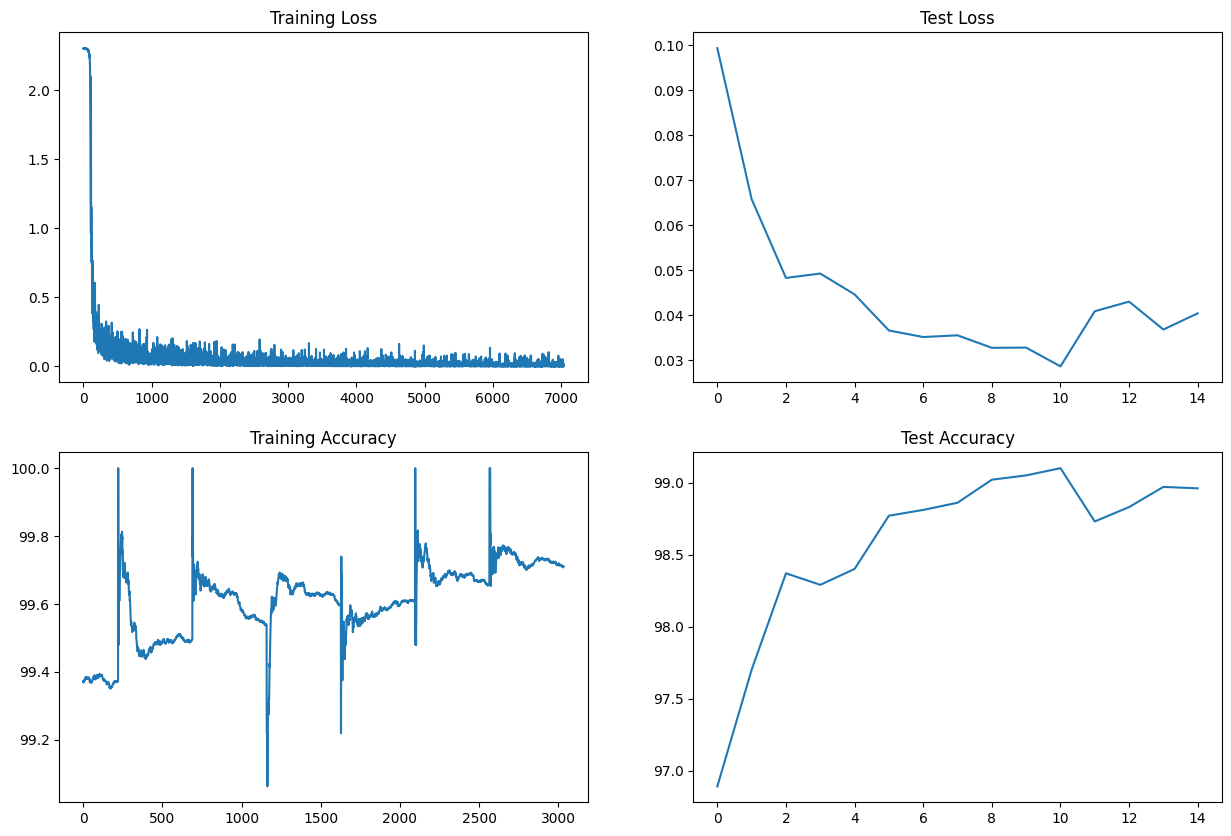

In [21]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Results:

<b>Parameters:</b> 49,248

<b>Best Train Accuracy:</b> 99.61

<b>Best Test Accuracy:</b> 99.16

<b>Analysis:</b>
The model parameters exceeds the required target and based on the training and test result we can see that the network is overfitting but still we can acheive the required target, let us try to reduce the parameters to the maximum